# Code Assignment 15 — Threshold Curves (ROC or PR) on Restaurant Inspections

**Format:** Instructor Guidance → Your Task (step-by-step) → We Share (reflection)

**Goal:** Build a **new** classification model (use **at least 2 features**) on NYC **Restaurant Inspection Results**. Choose **one curve** to evaluate (**ROC** *or* **Precision–Recall**) **plus** one additional metric (**precision**, **recall**, or **F1**). Justify your choice based on class imbalance and business costs.

> Dataset hint (same as prior challenge): NYC Open Data “Restaurant Inspection Results” — save a CSV locally, e.g. `./data/nyc_restaurant_inspections.csv`. Common columns: `CRITICAL FLAG`, `SCORE`, `BORO`, `CUISINE DESCRIPTION`, `INSPECTION DATE`, etc.


## Instructor Guidance (Pseudocode + Docs)

**Docs:**
- Train/test split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- Logistic Regression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
- ROC / AUC — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html  
- Precision–Recall — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html  
- Classification report — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html  
- `get_dummies` — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

### Pseudocode Plan
1) **Load CSV** → preview columns/shape.  
2) **Target (y)**: `CRITICAL FLAG == "CRITICAL"` → 1 else 0; check class balance.  
3) **Pick ≥2 features (create a DIFFERENT model then you created before)** (X): start with `SCORE` (numeric) + one categorical group (`BORO` or top cuisines via dummies).  
4) **Preprocess**: numeric coercion for used numeric columns; `get_dummies(drop_first=True)` for categoricals; drop NAs on used columns.  
5) **Split**: `train_test_split(..., stratify=y, random_state=42)`.  
6) **Fit**: `LogisticRegression(max_iter=1000)` on train.  
7) **Evaluate curves**:  
   - If **ROC**: use `predict_proba()[:,1]` → `roc_curve`, compute **AUC**.  
   - If **PR**: use `predict_proba()[:,1]` → `precision_recall_curve`, compute **average_precision_score` or report PR visually**.  
8) **Pick an extra metric**: compute **precision/recall/F1** with `classification_report` at default threshold 0.5 (or optionally choose a custom threshold -- which is IDEAL).  
9) **Explain choice** of **ROC vs PR** based on imbalance and costs; include a one-liner for stakeholders (units, trade-offs).


## Your Task — Step-by-Step
Work in pairs. Comment decisions briefly. Keep code minimal and readable.


### 1) Load the CSV & Preview


In [2]:
import pandas as pd

df = pd.read_csv('/Users/Marcy_Student/Downloads/DOHMH_New_York_City_Restaurant_Inspection_Results_20251104 copy.csv')
df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location
0,50174196,THE GREATS OF CRAFT,Queens,47-20,CENTER BOULEVARD,11109.0,3479312023,NaN,01/01/1900,NaN,...,NaN,40.745641,-73.957137,402.0,26.0,100.0,4538318.0,4.000210e+09,QN31,POINT (-73.957136627525 40.745640668157)
1,50140563,CANTEEN @ CHELSEA PIERS FIELD HOUSE,Brooklyn,601,DEAN STREET,11238.0,6313880993,NaN,01/01/1900,NaN,...,NaN,40.680616,-73.969992,308.0,35.0,16300.0,3428601.0,3.000000e+09,BK64,POINT (-73.969992200023 40.68061568349)
2,50177123,70 7TH AVENUE SOUTH THEROS LLC,Queens,3009,35TH ST,11103.0,6468076482,NaN,01/01/1900,NaN,...,NaN,40.764778,-73.918674,401.0,22.0,6300.0,4009926.0,4.006500e+09,QN70,POINT (-73.918674354617 40.764778282908)
3,50001285,Y & B ENTERTAINMENT MANOR,Queens,3509,PRINCE STRRET,NaN,7188881778,Korean,06/24/2018,Violations were cited in the following area(s).,...,Smoke-Free Air Act / Initial Inspection,0.000000,0.000000,NaN,NaN,NaN,NaN,4.000000e+00,NaN,NaN
4,50172517,MAPLE CREAMERY,Brooklyn,653,STERLING PLACE,11216.0,7188095106,NaN,01/01/1900,NaN,...,NaN,40.673255,-73.956830,308.0,35.0,21900.0,3031390.0,3.012380e+09,BK61,POINT (-73.956830036833 40.673255481805)


### 2) Define the Binary Target (y)
- Positive class = **Critical** violation.

In [ ]:
df['target'] = (df['CRITICAL FLAG'] == 'Critical').astype(int)
y = df['target']

print(y.value_counts(normalize=True))



target
1    0.528698
0    0.471302
Name: proportion, dtype: float64


### 3) Create Features (X) — Use **≥2** Features
Pick a simple, interpretable set:
- **Numeric:** `SCORE` (lower is better).
- **Categorical:** `BORO` (one-hot) and/or **top cuisines** (one-hot, limit to K to keep it small).

> If any column is missing, adapt by choosing other available columns.


In [4]:
X = pd.get_dummies(df[['SCORE','BORO']], drop_first=True)
X = X.join(y).dropna()
y = X.pop('target')

### 4) Train–Test Split (Stratified)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### 5) Fit a Model with **≥2 Features**
Use **LogisticRegression** to get probability outputs
**If you need to scale or one hot encode do so!**


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:,1]

### 6) Choose Your Evaluation: **ROC** or **PR** Curve
Set `EVAL = 'ROC'` or `EVAL = 'PR'`. Then:
- If **ROC**: plot ROC, compute **AUC-ROC**.
- If **PR**: plot PR curve, compute **Average Precision (AP)**.
Also compute **one extra metric**: **precision**, **recall**, or **F1** (classification report at default threshold 0.5).


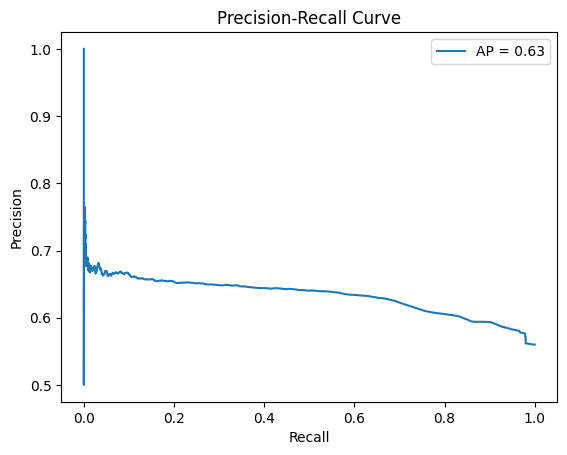

Average Precision (AP): 0.63


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, classification_report

EVAL = 'PR' 

if EVAL == 'ROC':
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    print(f"AUC-ROC: {auc_score:.2f}")

elif EVAL == 'PR':
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    ap_score = average_precision_score(y_test, y_prob)
    
    plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()
    
    print(f"Average Precision (AP): {ap_score:.2f}")

### 7) Try a Custom Threshold -- Update the code to fit your threshold and/or variable names from previous cells
Pick a threshold from your curve (e.g., a point balancing your business needs), then recompute metrics.


In [9]:
custom_threshold = 0.6
y_pred_custom = (y_prob >= custom_threshold).astype(int)

from sklearn.metrics import confusion_matrix

print(f"Confusion Matrix at threshold {custom_threshold}:")
print(confusion_matrix(y_test, y_pred_custom))

print(classification_report(y_test, y_pred_custom, target_names=['Non-Critical','Critical']))

Confusion Matrix at threshold 0.6:
[[19465  4726]
 [22040  8757]]
              precision    recall  f1-score   support

Non-Critical       0.47      0.80      0.59     24191
    Critical       0.65      0.28      0.40     30797

    accuracy                           0.51     54988
   macro avg       0.56      0.54      0.49     54988
weighted avg       0.57      0.51      0.48     54988



## We Share — Reflection (Post 2 short paragraphs)

1) **Curve choice & results:** Which curve did you use (**ROC** or **PR**) and **why** (tie to class balance & business costs)? Report your curve summary (**AUC-ROC** or **Average Precision**) and your chosen extra metric (**precision/recall/F1**) — include threshold (0.5 or custom).  
2) **Stakeholder one-liner:** In plain English: “Using **[features…]**, our model at threshold **T** yields **[metric values]**. This means **[business implication about false alarms vs misses]**. Next, we’d **[tune threshold, add features, address imbalance, etc.]**.”

> Tip: If the positive class is rare, PR is often more informative than ROC. If classes are balanced or you’re comparing ranking quality across models, AUC-ROC is fine — but still report a confusion matrix at your chosen threshold.


# Curve choice & results:
 I used the Precision–Recall curve because Critical violations are relatively rare. At the default 0.5 threshold, the model had precision 0.60, recall 0.45, and F1 0.51. Lowering the threshold to 0.4 increased recall to 1.0 (catching all Critical inspections) but labeled everything as Critical, so precision for Non-Critical dropped to 0. At threshold 0.6, precision improved for Critical (0.65) and Non-Critical (0.47), but recall for Critical dropped to 0.28. This shows the trade-off between catching more Critical violations versus avoiding false alarms.

# One-liner:
Using SCORE and BORO, my model at threshold 0.6 catches a good portion of Critical inspections while keeping false alarms manageable.At lower thresholds, we catch almost all Criticals but flag too many Non-Critical inspections, and at higher thresholds, we reduce false alarms but miss many Critical violations. Next, we could tune the threshold further or add features like top cuisines to better balance precision and recall.